<a href="https://colab.research.google.com/github/heejvely/NLP_models/blob/main/BERT(Bidirectional_Encoder_Representations_from_Transformers)%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 코드 참조: https://paul-hyun.github.io/bert-01/

# 0. Pip install
필요한 패키지를 pip를 이용해서 설치합니다.

In [2]:
!pip install sentencepiece
!pip install wget

In [3]:
# gpu 설정
!nvidia-smi

Sun Jan  2 09:43:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Imports

In [4]:
import os
import numpy as np
import math
from random import random, randrange, randint, shuffle, choice
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

# 2. Vocab 및 입력
Sentencepiece를 활용해 Vocab 만들기를 통해 만들어 놓은 vocab을 로딩합니다.

In [5]:
import sentencepiece as spm
# vocab loading
vocab_file = '/content/drive/MyDrive/colab/NLP_모델/kowiki_corpus/kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

# 3. Config

- Transformer와 파라미터를 동일하게 설정
- BERT는 Encoder만 사용하므로 항목 중 Decoder 부분 제거
- 기본 입력에 추가로 segment 정보를 입력 받는데, Segment 수를 정의하는 n_seg_type을 추가로 정의

In [6]:
"""configuration json을 읽어들이는 class"""
class Config(dict):
  __getattr__ = dict.__getitem__
  __setarrt__ = dict.__setitem__

  @classmethod
  def load(cls, file):
    with open(file, 'r') as f:
      config = json.loads(f.read())
      return Config(config)

In [7]:
config = Config({
    'n_enc_vocab': len(vocab),
    'n_enc_seq': 256,
    'n_seg_type': 2,
    'n_layer': 6,
    'd_hidn': 256,
    'i_pad': 0,
    'd_ff': 1024,
    'n_head': 4,
    'd_head': 64,
    'dropout': 0.1,
    'layer_norm_epsilon': 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


# 4. Common Class
공통으로 사용되는 Class 및 함수

In [8]:
"""sinusoid position encoding"""
def get_sinusoid_encoding_table(n_seq, d_hidn):
  def cal_angle(position, i_hidn):
    return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
  def get_posi_angle_vec(position):
    return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

  sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])  # 1. 각 position별 hidden index별 angle 값을 구합니다.
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])                         # 2. hidden 짝수 index의 angle값의 sin값을 구합니다.
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])                         # 3. hidden 홀수 index의 angle값의 cos값을 구합니다.

  return sinusoid_table

"""attention pad mask"""
def get_attn_pad_mask(seq_q, seq_k, i_pad):
  batch_size, len_q = seq_q.size()
  batch_size, len_k = seq_k.size()
  pad_attn_mask = seq_k.data.eq(i_pad)                                              # 1. K의 값 중에 Pad인 부분을 True로 변경합니다.(나머지는 False)
  pad_attn_mask = pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)       # 2. 구해진 값의 크기를 Q-len, K-len 되도록 변경합니다.
  return pad_attn_mask

"""attention decoder mask"""
def get_attn_decoder_mask(seq):
  subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1)) # 1. 모든 값이 1인 Q-len, K-leb 테이블을 생성합니다.
  subsequent_mask = subsequent_mask.triu(diagonal=1)                                                 # 2. 대각선을 기준으로 아래쪽을 0으로 만듭니다.
  return subsequent_mask

"""scale dot product attention"""
class ScaledDotProductAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.dropout= nn.Dropout(config.dropout)
    self.scale = 1 / (self.config.d_head ** 0.5)

  def forward(self, Q, K, V, attn_mask):
    scores = torch.matmul(Q, K.transpose(-1, -2))     # 1. Q * K.transpose를 구합니다.
    scores = scores.mul_(self.scale)                   # 2. K-dimention에 루트를 취한 값으로 나눠 줍니다.
    scores.masked_fill_(attn_mask, -1e9)              # 3. Mask를 적용합니다.

    attn_prob = nn.Softmax(dim= -1)(scores)           # 4. Softmax를 취해 각 단어의 가중치 확률분포 attn_prob를 구합니다.
    attn_prob = self.dropout(attn_prob)               # 5. attn_prob * V를 구합니다. 구한 값은 Q에 대한 V의 가중치 합 벡터입니다.

    context = torch.matmul(attn_prob, V)

    return context, attn_prob

"""multi head attention"""
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.scaled_dot_attn = ScaledDotProductAttention(self.config)
    self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, Q, K, V, attn_mask):
    batch_size = Q.size(0)
    q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 1. Q * W_Q를 한 후 multi-head로 나눕니다.
    k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 2. K * W_K를 한 후 multi-head로 나눕니다.
    v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 3. V * W_V를 한 후 multi-head로 나눕니다.

    attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

    context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)                                             # 4. ScaledDotProductAttention 클래스를 이용해 각 head 별 Attention을 구합니다.
    context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)    # 5. 여러 개의 head를 1개로 합칩니다.
    output = self.linear(context)                                                                                   # 6. Linear를 취해 최종 Multi-Head Attention값을 구합니다.
    output = self.dropout(output)
    
    return output, attn_prob

"""feed forward"""
class PoswiseFeedForwardNet(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.conv1 = nn.Conv1d(in_channels = self.config.d_hidn, out_channels = self.config.d_ff, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels = self.config.d_ff, out_channels = self.config.d_hidn, kernel_size=1)
    self.active = F.gelu
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, inputs):
    output = self.conv1(inputs.transpose(1, 2))     # 1. Linear를 실행하여 shape을 d_ff(hidden * 4)크기로 키웁니다.
    output = self.active(output)                    # 2. activation 함수(relu or gelu)를 실행합니다.

    output = self.conv2(output).transpose(1, 2)     # 3. Linear를 실행하여 shape을 hidden 크기로 줄입니다.
    output = self.dropout(output)

    return output

# 5. Encoder
BERT는 표준 Transformer의 Decoder는 사용하지 않고 Encoder만 사용합니다.

Position Embedding 학습, Segment Embedding 추가 두가지 이외에 나머지 부분은 표준 Transformer와 동일합니다.

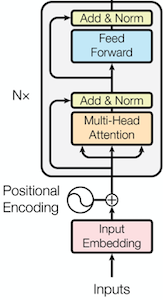

#### Encoder Layer
표준 Transformer EncoderLayer와 동일합니다.

In [9]:
"""encoder layer"""
class EncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.self_attn = MultiHeadAttention(self.config)
    self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)
    self.pos_ffn = PoswiseFeedForwardNet(self.config)
    self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)

  def forward(self, inputs, attn_mask):
    attn_outputs, attn_prob = self.self_attn(inputs, inputs, inputs,attn_mask)    # 1. Multi-Head Attention을 수행합니다. Q, K, V 모두 동일한 값을 사용하는 self-attention입니다.
    attn_outputs = self.layer_norm1(inputs + attn_outputs)                        # 2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행합니다.

    ffn_outputs = self.pos_ffn(attn_outputs)                                      # 3. 2번의 결과를 입력으로 Feed Forward를 실행합니다.
    ffn_outputs = self.layer_norm2(ffn_outputs + attn_outputs)                    # 4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.

    return ffn_outputs, attn_prob

#### Encoder
표준 Transformer Encoder와 아래 내용이 다릅니다.

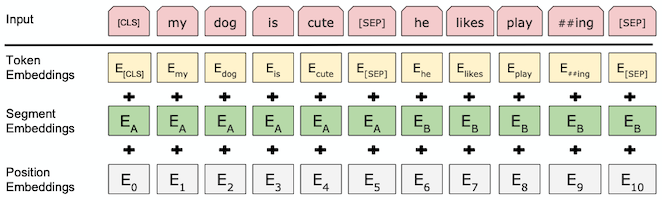

1. Position을 학습할 수 있도록 하였습니다.
  - 표준 Transformer에서는 sinusoid encoding을 구한 후 이 값으로 position embedding을 초기화 할 때 freeze 옵션을 True로 주어 Position embedding이 학습되지 않도록 하였습니다.
  - BERT는 position embedding을 기본 값으로 초기화 한 후 학습되도록 하였습니다.

2. Segment Embedding을 추가했습니다.
  - Segment Embedding은 위 그림과 같이 두개의 문장이 들어갈 경우 첫 번째 문장과 두번째 문장을 구분하기 위해 사용됩니다.

3. Encoder input에 Segment 정보를 추가했습니다.

4. Token, Position 및 Segment 3가지 Embedding을 더 합니다.
  - 표준 Transformer에서는 Token, Position 2가지 Embedding을 더 합니다.

나머지는 Transforemr Encoder와 동일합니다.

In [10]:
"""encoder"""
class Encoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
    self.pos_emb = nn.Embedding(self.config.n_enc_seq + 1, self.config.d_hidn)                      # 1. Position을 학습할 수 있도록 하였습니다.
    self.seg_emb = nn.Embedding(self.config.n_seg_type, self.config.d_hidn)                         # 2. Segment Embedding을 추가했습니다.

    self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])

  def forward(self, inputs, segments):                                                              # 3. Encoder input에 Segment 정보를 추가했습니다.
    positions = torch.arange(inputs.size(1), device = inputs.device, dtype = inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
    pos_mask = inputs.eq(self.config.i_pad)
    positions.masked_fill_(pos_mask, 0)

    outputs = self.enc_emb(inputs) + self.pos_emb(positions) + self.seg_emb(segments)               # 4. Token, Position 및 Segment 3가지 Embedding을 더 합니다.
   
    attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)
    
    attn_probs = []
    for layer in self.layers:
      outputs, attn_prob = layer(outputs, attn_mask)
      attn_probs.append(attn_prob)
    
    return outputs, attn_probs

# 6. BERT
BERT 모델 클래스

1. BERT는 Transformer Encoder를 실행합니다.
2. 1번의 결과(outputs)의 첫 번째([CLS]) Token을 output_cls로 저장합니다.
3. outputs_cls에 Linear 및 tanh을 실행합니다.
4. Pretrain된 모델을 저장하기위한 save 함수입니다.
5. Pretrain된 모델을 읽기위한 load 함수 입니다.

In [11]:
"""bert"""
class BERT(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.encoder = Encoder(self.config)

    self.linear = nn.Linear(config.d_hidn, config.d_hidn)
    self.activation = torch.tanh

  def forward(self, inputs, segments):
    outputs, self_attn_probs = self.encoder(inputs, segments)     # 1. BERT는 Transformer Encoder를 실행합니다.

    outputs_cls = outputs[:, 0].contiguous()                      # 2. 1번의 결과(outputs)의 첫 번째([CLS]) Token을 output_cls로 저장합니다.
    outputs_cls = self.linear(outputs_cls)                        # 3. outputs_cls에 Linear 및 tanh을 실행합니다.
    outputs_cls = self.activation(outputs_cls)

    return outputs, outputs_cls, self_attn_probs

  def save(self, epoch, loss, path):                              # 4. Pretrain된 모델을 저장하기위한 save 함수입니다.
    torch.save({
        'epoch': epoch,
        'loss': loss,
        'state_dict': self.state_dict()
    }, path)

  def load(self, path):                                           # 5. Pretrain된 모델을 읽기위한 load 함수 입니다.
    save = torch.load(path)
    self.load_state_dict(save['state_dict'])
    return save['epoch'], save['loss']

# 7. Pretrain Model
BERT를 Pretrain 하기 위한 목적함수는 다음 두가지 입니다.

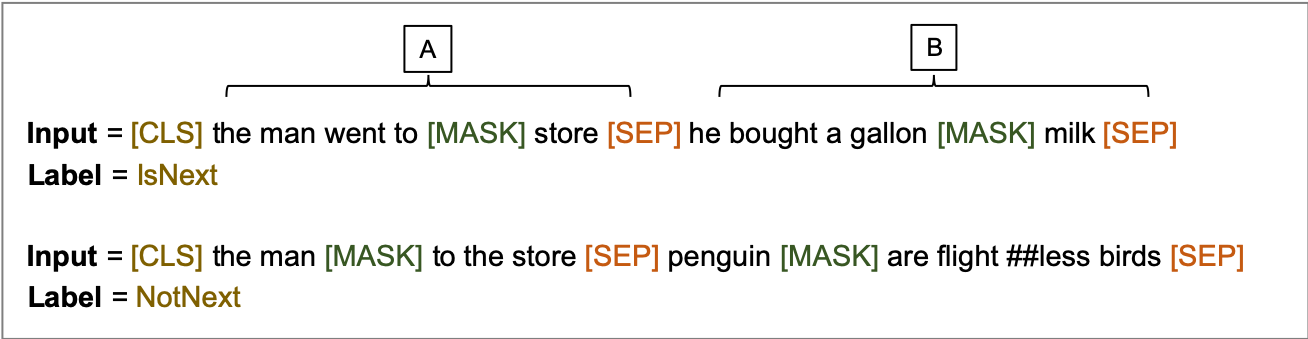

1. MLM(Masked Language Model)
  - 위 그림과 같이[MASK]된 부분의 단어를 예측하는 것을 MLM이라 합니다.
  - 전체 단어의 15% 를 선택한 후 그중 80%는 [MASK], 10%는 현재 단어 유지, 10%는 임의의 단어로 대체합니다.

2. NSP(Next Sentence Prediction)
  - 위 그림과 같이 첫번쨰([CLS])Token으로 문장 A와 문장 B의 관계를 예측하는 것을 NSP라 합니다.
  - A 다음 문장이 B가 맞을 경우는 True(IsNext), A 다음 문장이 B가 아닐 경우 False(NotNext)로 예측하도록 합니다.

BERT를 Pretrain 하기 위한 클래스

1. BERT의 결과를 입력으로 NSP를 예측하기 위한 projection_cls를 선언합니다.
2. BERT의 결과를 입력으로 MLM을 예측하기 위한 projection_lm을 선언합니다.
3. projection_lm은 Encoder의 Embedding과 weight를 share합니다.
4. inputs, segments를 입력으로 BERT를 실행합니다.
5. outputs_cls를 입력으로 projection_cls를 실행하여 NSP를 예측하도록 합니다.
6. outputs를 입력으로 projection_lm을 실행하여 MLM을 예측하도록합니다.

In [12]:
"""BERT pretrain"""
class BERTPretrain(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.bert = BERT(self.config)
    # classifier
    self.projection_cls = nn.Linear(self.config.d_hidn, 2, bias = False)                          # 1. BERT의 결과를 입력으로 NSP를 예측하기 위한 projection_cls를 선언합니다.
    # lm
    self.projection_lm = nn.Linear(self.config.d_hidn, self.config.n_enc_vocab, bias = False)     # 2. BERT의 결과를 입력으로 MLM을 예측하기 위한 projection_lm을 선언합니다.
    self.projection_lm.weight = self.bert.encoder.enc_emb.weight                                  # 3. projection_lm은 Encoder의 Embedding과 weight를 share합니다.

  def forward(self, inputs, segments):
    outputs, outputs_cls, attn_probs = self.bert(inputs, segments)                                # 4. inputs, segments를 입력으로 BERT를 실행합니다.
    logits_cls = self.projection_cls(outputs_cls)                                                 # 5. outputs_cls를 입력으로 projection_cls를 실행하여 NSP를 예측하도록 합니다.
    logits_lm = self.projection_lm(outputs)                                                       # 6. outputs를 입력으로 projection_lm을 실행하여 MLM을 예측하도록합니다.
    return logits_cls, logits_lm, attn_probs

# 8. Pretrain Data 생성

#### [MASK] 생성 함수
마스크를 생성하는 함수

1. Token을 단어별로 index 배열 형태로 저장합니다.
  - u"\u2582"은 단어의 시작을 의미하는 값으로 시작하지 않으면 이전 Token과 연결된 subword입니다.
2. Random 선택을 위해 단어의 index를 섞습니다.
3. index를 for loop를 돌며 아래 내용(4 ~9)을 실행합니다.
4. mask_lms의 개수가 mask_cnt를 넘지 않도록 합니다.
  - mask_cnt는 전체 token 개수의 15%에 해당하는 개수입니다.
5. index에 대해 80% 확률로 [MASK]를 취합니다.
6. index에 대해 10% 확률로 현재 값을 유지합니다.
7. index에 대해 10% 확률로 vocab_list에서 임의의 값을 선택합니다.
8. mask된 index의 값과 정답 label을 mask_lms에 저장합니다.
9. token index의 값을 mask합니다.
10. Random하게 mask된 값을 index 순으로 정렬합니다.
11. 10번에서 정렬된 값을 이용해 mask_index, mask_label를 만듭니다.

In [13]:
"""마스크 생성"""
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
  cand_idx = []
  for (i, token) in enumerate(tokens):                            # 1. Token을 단어별로 index 배열 형태로 저장합니다.
    if token == '[CLS]' or token == '[SEP]':
      continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
      cand_idx[-1].append(i)
    else:
      cand_idx.append([i])
  shuffle(cand_idx)                                               # 2. Random 선택을 위해 단어의 index를 섞습니다.

  mask_lms = []
  for index_set in cand_idx:                                      # 3. index를 for loop를 돌며 아래 내용(4 ~9)을 실행합니다.
    if len(mask_lms) >= mask_cnt:                                 # 4. mask_lms의 개수가 mask_cnt를 넘지 않도록 합니다.
      break
    if len(mask_lms) + len(index_set) > mask_cnt:
      continue
    for index in index_set:
      masked_token = None
      if random() < 0.8:                                          # 5. index에 대해 80% 확률로 [MASK]를 취합니다.
        masked_token = '[MASK]'
      else:
        if random() < 0.5:                                        # 6. index에 대해 10% 확률로 현재 값을 유지합니다.
          masked_token = tokens[index]
        else:                                                     # 7. index에 대해 10% 확률로 vocab_list에서 임의의 값을 선택합니다.
          masked_token = choice(vocab_list)
      mask_lms.append({'index':index, 'label':tokens[index]})     # 8. mask된 index의 값과 정답 label을 mask_lms에 저장합니다.
      tokens[index] = masked_token                                # 9. token index의 값을 mask합니다.
  mask_lms = sorted(mask_lms, key = lambda x: x['index'])         # 10. Random하게 mask된 값을 index 순으로 정렬합니다.
  mask_idx = [p['index'] for p in mask_lms]                       # 11. 10번에서 정렬된 값을 이용해 mask_index, mask_label를 만듭니다.
  mask_label = [p['label'] for p in mask_lms]

  return tokens, mask_idx, mask_label

#### 최대 길이 초과하는 Token 자르기
token A, token B의 길이의 합이 특정 길이보다 클 경우 이를 줄이는 함수입니다.

1. token A의 길이가 길 경우 앞에서부터 토큰을 제거합니다.
2. token B의 길이가 길 경우 뒤에서부터 토큰을 제거합니다.

In [14]:
"""최대 길이 초과하는 토큰 자르기"""
def trim_tokens(tokens_a, tokens_b, max_seq):
  while True:
    total_length = len(tokens_a) + len(tokens_b)
    if total_length <= max_seq:
      break

    if len(tokens_a) > len(tokens_b):       # 1. token A의 길이가 길 경우 앞에서부터 토큰을 제거합니다.
      del tokens_a[0]
    else:                                   # 2. token B의 길이가 길 경우 뒤에서부터 토큰을 제거합니다.
      tokens_b.pop()

#### 단락별 pretrain 데이터 생성 함수
단락을 여러 개의 Pretrain 데이터로 만드는 함수입니다.

1. 특수 Token은 시작'[CLS]', 구분자 '[SEP]' 2개 입니다.
  - tgt_seq는 n_seq에서 3개를 뺀 값입니다.
2. 단락을 줄 단위로 for loop를 돌며 아래내용(3 ~ 12)을 실행합니다.
3. current_chunk에 line을 추가, current_length에 라인의 token수를 더합니다.
4. 마지막 줄이거나 current_length가 tgt_seq를 넘을 경우 학습데이터를 만듭니다.
5. current_chunk에서 Random하게 길이를 선택해서 toknes_a를 만듭니다.
6. 50%의 확률로 다른 단락에서 tokens_b를 만듭니다.
7. is_next의 값은 False(0)입니다.
8. 50%의 확률로 current_chunk에서 tokens_a 이후부터 tokens_b를 만듭니다.
9. is_next의 값은 True(1)입니다.
10. 위에서 정의한 trim_tokens 함수를 실행하여 token 크기를 줄입니다.
11. '[CLS]' + token_a + '[SEP]' + tokens_b + '[SEP]' 형태로 데이터를 생성합니다.
12. segment를 생성합니다.
  - 9번에서 '[CLS]' + tokens_a + '[SEP]'는 0, tokens_b + '[SEP]'는 1입니다.
13. 위에서 정의한 create_pretrain_mask 함수를 실행하여 Mask 합니다.
  - Mask Token 개수는 전체 Token 수에 0.15(15%)를 곱해서 구합니다.
14. 위 결과를 가지고 데이터를 생성합니다.

In [15]:
"""doc 별 pretrain 데이터 생성"""
def create_pretrain_instances(docs, doc_idx, doc, n_seq, mask_prob, vocab_list):
  max_seq = n_seq - 3                                         # 1. 특수 Token은 시작'[CLS]', 구분자 '[SEP]' 2개 입니다.
  tgt_seq = max_seq

  instances = []
  current_chunk = []
  current_length = 0
  for i in range(len(doc)):                                   # 2. 단락을 줄 단위로 for loop를 돌며 아래내용(3 ~ 12)을 실행합니다.
    current_chunk.append(doc[i])                              # 3. current_chunk에 line을 추가, current_length에 라인의 token수를 더합니다.
    current_length += len(doc[i])
    if i == len(doc) - 1 or current_length >= tgt_seq:         # 4. 마지막 줄이거나 current_length가 tgt_seq를 넘을 경우 학습데이터를 만듭니다.
      if 0 < len(current_chunk):
        a_end = 1                                             # 5. current_chunk에서 Random하게 길이를 선택해서 toknes_a를 만듭니다.
        if 1 < len(current_chunk):
          a_end = randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
          tokens_a.extend(current_chunk[j])

        tokens_b = []
        if len(current_chunk) == 1 or random() < 0.5:         # 6. 50%의 확률로 다른 단락에서 tokens_b를 만듭니다.
          is_next = 0                                         # 7. is_next의 값은 False(0)입니다.
          token_b_len = tgt_seq - len(tokens_a)
          random_doc_idx = doc_idx
          while doc_idx == random_doc_idx:
            random_doc_idx = randrange(0, len(docs))
          random_doc = docs[random_doc_idx]

          random_start = randrange(0, len(random_doc))
          for j in range(random_start, len(random_doc)):
            tokens_b.extend(random_doc[j])

        else:                                                 # 8. 50%의 확률로 current_chunk에서 tokens_a 이후부터 tokens_b를 만듭니다.
          is_next = 1                                         # 9. is_next의 값은 True(1)입니다.
          for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
        
        trim_tokens(tokens_a, tokens_b, max_seq)              # 10. 위에서 정의한 trim_tokens 함수를 실행하여 token 크기를 줄입니다.
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        tokens = ['[CLS]'] + tokens_a + ['[SEP]'] + tokens_b + ['[SEP]']                # 11. '[CLS]' + token_a + '[SEP]' + tokens_b + '[SEP]' 형태로 데이터를 생성합니다.
        segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)                 # 12. segment를 생성합니다.

        tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)   # 13. 위에서 정의한 create_pretrain_mask 함수를 실행하여 Mask 합니다.
        instance = {                                          # 14. 위 결과를 가지고 데이터를 생성합니다.
            'tokens': tokens,
            'segment': segment,
            'is_next': is_next,
            'mask_idx': mask_idx,
            'mask_label': mask_label
        }
        instances.append(instance)

      current_chunk = []
      current_length = 0
  return instances

#### pretrain 데이터 생성 함수
말뭉치를 읽어 Pretrain 데이터를 만드는 함수입니다.

1. 단어목록 vocab_list를 생성합니다. 생성 시 unknown은 제거합니다.
  - voacb_list는 위에서 정의한 create_pretrain_mask 함수의 입력으로 사용하기 위함입니다.
2. 말뭉치 파일 라인수를 확인합니다.
3. 말뭉치를 줄 단위로 for loop를 돌며 아래내용(3~4)을 실행합니다.
4. 줄의 문자를 vocab을 이용해 tokenize한 후 doc에 추가합니다.
5. 빈 줄이 나타날 경우 단락의 끝이므로 doc를 docs에 추가하고 doc를 새로 만듭니다.
6. count 횟수만큼 for loop를 돌며(7 ~ 9) Pretrain 데이터를 만듭니다.
  - BERT는 Mask를 15%만 하므로 한 번에 전체 단어를 학습할 수 없습니다. 한 말뭉치에 대해 통상 Pretrain 데이터 10개(150%)정도 만들어서 학습하도록 합니다.
7. docs(단락배열)을 doc(단락) 단위로 for loop를 돌며 아래 내용(6~7)을 실행 합니다.
8. doc를 입력으로 위에서 정의한 create_pretrain_instances 함수를 호출합니다.
9. 8번의 결과를 파일에 저장합니다.

In [16]:
""" pretrain 데이터 생성 """
def make_pretrain_data(vocab, in_file, out_file, count, n_seq, mask_prob):
  vocab_list = []                                                               # 1. 단어목록 vocab_list를 생성합니다. 생성 시 unknown은 제거합니다.
  for id in range(vocab.get_piece_size()):
    if not vocab.is_unknown(id):
      vocab_list.append(vocab.id_to_piece(id))

  line_cnt = 0                                                                  # 2. 말뭉치 파일 라인수를 확인합니다.
  with open(in_file,'r') as in_f:
    for line in in_f:
      line_cnt += 1

  docs = []
  with open(in_file, 'r') as f:                                                 # 3. 말뭉치를 줄 단위로 for loop를 돌며 아래내용(3~4)을 실행합니다.
    doc = []
    with tqdm(total=line_cnt, desc=f'Loading') as pbar:
      for i, line in enumerate(f):
        line = line.strip()
        if line == "":                                                          # 5. 빈 줄이 나타날 경우 단락의 끝이므로 doc를 docs에 추가하고 doc를 새로 만듭니다.
          if 0 < len(doc):
            docs.append(doc)
            doc = []
        else:
          pieces = vocab.encode_as_pieces(line)                                 # 4. 줄의 문자를 vocab을 이용해 tokenize한 후 doc에 추가합니다.
          if 0 < len(pieces):
            doc.append(pieces)
        pbar.update(1)
    if doc:                                                                     # 7. docs(단락배열)을 doc(단락) 단위로 for loop를 돌며 아래 내용(6~7)을 실행 합니다.
      docs.append(doc)
      
  for index in range(count):                                                    # 6. count 횟수만큼 for loop를 돌며(7 ~ 9) Pretrain 데이터를 만듭니다.
    output = out_file.format(index)
    if os.path.isfile(output): continue

    with open(output, 'w') as out_f:
      with tqdm(total=len(docs), desc = f'Making') as pbar:
        for i, doc in enumerate(docs):                                          # 8. doc를 입력으로 위에서 정의한 create_pretrain_instances 함수를 호출합니다.
          instances = create_pretrain_instances(docs, i, doc, n_seq, mask_prob, vocab_list)
          for instance in instances:                                            # 9. 8번의 결과를 파일에 저장합니다.
            out_f.write(json.dumps(instance))
            out_f.write('\n')
          pbar.update(1)

#### pretrain 데이터 생성 실행
pretrain 데이터를 만드는 코드입니다.

- 말뭉치 개수(count)는 10으로 합니다.
- sequence 길이(n_seq)는 256으로 합니다.
- Mask 확률(mask_prob)는 15%로 합니다.

In [17]:
# 약 50분 소요
in_file = '/content/drive/MyDrive/colab/NLP_모델/kowiki_corpus/kowiki.txt'
out_file = '/content/drive/MyDrive/colab/NLP_모델/BERT/kowiki_bert_{}.json'
count = 10
n_seq = 256
mask_prob = 0.15

make_pretrain_data(vocab, in_file, out_file, count, n_seq, mask_prob)

Loading: 100%|██████████| 4475042/4475042 [04:22<00:00, 17073.37it/s]


# 9. DataSet

#### DataSet
Pretrain DataSet입니다.

1. 입력 파일에서 아래 내용을 읽습니다.
  - is_next: tokens_a 와 tokens_b가 인접한 문장인지 여부
  - tokens: 문장 tokens
  - segment: tokens_a(0)와 tokens_b(1)을 구분하기 위한 값
  - mask_idx: tokens와 mask index
  - mask_label: tokens내의 mask된 부분의 정답

2. 값이 모두 -1인 label_lm변수를 만듭니다.
3. label_lm의 mask_idx 위치에 mask_label값을 저장합니다.
  - 이렇게 하면 mask_idx 위치는 mask_label이 나머지는 -1이 됩니다.

In [18]:
""" pretrain 데이터셋"""
class PretrainDataSet(torch.utils.data.Dataset):
  def __init__(self, vocab, infile):
    self.vocab = vocab
    self.labels_cls = []
    self.labels_lm = []
    self.sentences = []
    self.segments = []

    line_cnt = 0
    with open(infile, 'r') as f:
      for line in f:
        line_cnt += 1

    with open(infile, 'r') as f:
      for i, line in enumerate(tqdm(f, total=line_cnt, desc=f'Loading {infile}', unit=' lines')):
        instance = json.loads(line)

        # 1. 입력 파일에서 아래 내용을 읽습니다.
        #   - is_next: tokens_a 와 tokens_b가 인접한 문장인지 여부
        #   - tokens: 문장 tokens
        #   - segment: tokens_a(0)와 tokens_b(1)을 구분하기 위한 값
        #   - mask_idx: tokens와 mask index
        #   - mask_label: tokens내의 mask된 부분의 정답
        self.labels_cls.append(instance['is_next'])
        sentences = [vocab.piece_to_id(p) for p in instance['tokens']]
        self.sentences.append(sentences)
        self.segments.append(instance['segment'])
        mask_idx = np.array(instance['mask_idx'], dtype = np.int)
        mask_label = np.array([vocab.piece_to_id(p) for p in instance['mask_label']], dtype = np.int)
        label_lm = np.full(len(sentences), dtype = np.int, fill_value = -1)     # 2. 값이 모두 -1인 label_lm변수를 만듭니다.
        label_lm[mask_idx] = mask_label                                         # 3. label_lm의 mask_idx 위치에 mask_label값을 저장합니다.    
        self.labels_lm.append(label_lm)

  def __len__(self):
    assert len(self.labels_cls) == len(self.labels_lm)
    assert len(self.labels_cls) == len(self.sentences)
    assert len(self.labels_cls) == len(self.segments)
    return len(self.labels_cls)

  def __getitem__(self, item):
    return (torch.tensor(self.labels_cls[item]),
            torch.tensor(self.labels_lm[item]),
            torch.tensor(self.sentences[item]),
            torch.tensor(self.segments[item]))

#### collate_fn
배치단위로 데이터 처리를 위한 collate_fn입니다.

1. labels_lm의 길이가 같아지도록 짧은 문장에 padding(-1)을 추가합니다.
2. inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
  - padding은 Sentencepiece를 활용해 Vocab 만들기에서 '-pad_id=0' 옵션으로 지정한 값입니다.
3. segments의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
4. labels_cls는 길이가 1 고정이므로 stack 함수를 이용해 tensor로 만듭니다.

In [19]:
"""pretrain data collate_fn"""
def pretrain_collate_fn(inputs):
  labels_cls, labels_lm, inputs, segments = list(zip(*inputs))

  labels_lm = torch.nn.utils.rnn.pad_sequence(labels_lm, batch_first=True, padding_value = -1)  # 1. labels_lm의 길이가 같아지도록 짧은 문장에 padding(-1)을 추가합니다.
  inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value = 0)         # 2. inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
  segments = torch.nn.utils.rnn.pad_sequence(segments, batch_first=True, padding_value = 0)     # 3. segments의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.

  batch = [
           torch.stack(labels_cls, dim=0),                                                      # 4. labels_cls는 길이가 1 고정이므로 stack 함수를 이용해 tensor로 만듭니다.
           labels_lm,
           inputs,
           segments
  ]
  return batch

#### DataLoader
위에서 정의한 DataSet과 collate_fn을 이용해 학습용(train_loader) DataLoader를 만듭니다.

위에서 생성한 pretrain 데이터 중 첫 번째 값을 읽습니다.

In [20]:
# 약 5분 소요

"""pretrain 데이터 로더"""
batch_size = 128
dataset = PretrainDataSet(vocab, '/content/drive/MyDrive/colab/NLP_모델/BERT/kowiki_bert_0.json')
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=True, collate_fn = pretrain_collate_fn)

Loading /content/drive/MyDrive/colab/NLP_모델/BERT/kowiki_bert_0.json: 100%|██████████| 930403/930403 [05:06<00:00, 3031.66 lines/s]


# 10. Pretrain

#### Train
BERT 모델을 Pretrain 하기 위한 함수입니다.

1. inputs, segments를 입력으로 BERTPretrain을 실행합니다.
2. 1번의 결과 중 첫 번째 값이 NSP(logits_cls), 두 번째 값이 MLM(logits_lm)입니다.
3. logits_cls 값과 labels_cls 값을 이용해 NSP Loss(loss_cls)를 계산합니다.
4. logits_lm 값과 labels_lm 값을 이용해 MLM Loss(loss_lm)를 계산합니다.
5. loss_cls와 loss_lm을 더해 loss를 생성합니다.
6. loss, optimizer를 이용해 학습합니다.

In [21]:
"""모델 epoch 학습"""
def train_epoch(config, epoch, model, criterion_lm, criterion_cls, optimizer, train_loader):
  losses = []
  model.train()

  with tqdm(total=len(train_loader), desc = f'Train({epoch})') as pbar:
    for i, value in enumerate(train_loader):
      labels_cls, labels_lm, inputs, segments = map(lambda v: v.to(config.device), value)

      optimizer.zero_grad()
      outputs = model(inputs, segments)                                                       # 1. inputs, segments를 입력으로 BERTPretrain을 실행합니다.
      logits_cls, logits_lm = outputs[0], outputs[1]                                          # 2. 1번의 결과 중 첫 번째 값이 NSP(logits_cls), 두 번째 값이 MLM(logits_lm)입니다.

      loss_cls = criterion_cls(logits_cls, labels_cls)                                        # 3. logits_cls 값과 labels_cls 값을 이용해 NSP Loss(loss_cls)를 계산합니다.
      loss_lm = criterion_lm(logits_lm.view(-1, logits_lm.size(2)), labels_lm.view(-1))       # 4. logits_lm 값과 labels_lm 값을 이용해 MLM Loss(loss_lm)를 계산합니다.
      loss = loss_cls + loss_lm                                                               # 5. loss_cls와 loss_lm을 더해 loss를 생성합니다.

      loss_val = loss_lm.item()
      losses.append(loss_val)

      loss.backward()                                                                         # 6. loss, optimizer를 이용해 학습합니다.
      optimizer.step()

      pbar.update(1)
      pbar.set_postfix_str(f'Loss: {loss_val:.3f} ({np.mean(losses):.3f})')
  return np.mean(losses)


학습을 위한 추가적인 내용을 선언합니다.

1. GPU 사용 여부를 확인합니다.
2. learning_rate 및 학습 epoch를 선언합니다.

In [22]:
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    # 1. GPU 사용 여부를 확인합니다.
print(config)

learning_rate = 5e-5                                                            # 2. learning_rate 및 학습 epoch를 선언합니다.
n_epoch = 5

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


위에서 선언된 내용을 이용해 학습을 실행하는 절차입니다.

1. BERTPretrain을 생성합니다.
2. 기존에 학습된 pretrain 값이 있다면 이를 로드합니다.
3. BERTPretrain이 GPU 또는 CPU를 지원하도록 합니다.
4. MLM loss(criterion_lm) 및 NLP loss(criterion_cls) 함수를 선언합니다.
5. optimizer를 선언합니다.
6. 각 epoch 마다 새로 train_loader를 생성합니다.
  - step이 0인 경우는 위에서 생성했기 때문에 생성하지 않습니다.
7. 각 epoch 마다 학습을 합니다.

In [23]:
# epoch 1당 약 1시간 소요
# 중간에 RAM 초과 계속 진행 
model = BERTPretrain(config)                                                            # 1. BERTPretrain을 생성합니다.

save_pretrain = '/content/drive/MyDrive/colab/NLP_모델/BERT/save_bert_pretrain.pth'
best_epoch, best_loss = 0, 0
if os.path.isfile(save_pretrain):                                                       # 2. 기존에 학습된 pretrain 값이 있다면 이를 로드합니다.
  best_epoch, best_loss = model.bert.load(save_pretrain)
  print(f'load pretrain from: {save_pretrain}, epoch = {best_epoch}, loss = {best_loss}')
  best_epoch += 1

model.to(config.device)                                                                 # 3. BERTPretrain이 GPU 또는 CPU를 지원하도록 합니다.

criterion_lm = torch.nn.CrossEntropyLoss(ignore_index = -1, reduction='mean')           # 4. MLM loss(criterion_lm) 및 NLP loss(criterion_cls) 함수를 선언합니다.
criterion_cls = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)                    # 5. optimizer를 선언합니다.

losses = []
offset = best_epoch
for step in range(n_epoch):
  epoch = step + offset
  if 0 < step:                                                                          # 6. 각 epoch 마다 새로 train_loader를 생성합니다.
    del train_loader
    dataset = PretrainDataSet(vocab, f'/content/drive/MyDrive/colab/NLP_모델/BERT/kowiki_bert_{epoch % count}.json')
    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, collate_fn = pretrain_collate_fn)

  loss = train_epoch(config, epoch, model, criterion_lm, criterion_cls, optimizer, train_loader)      # 7. 각 epoch 마다 학습을 합니다.
  losses.append(loss)
  model.bert.save(epoch, loss, save_pretrain)

load pretrain from: /content/drive/MyDrive/colab/NLP_모델/BERT/save_bert_pretrain.pth, epoch = 2, loss = 6.7877650272733066


Train(3): 100%|██████████| 7269/7269 [52:49<00:00,  2.29it/s, Loss: 6.704 (6.725)]
Loading /content/drive/MyDrive/colab/NLP_모델/BERT/kowiki_bert_4.json: 100%|██████████| 930403/930403 [05:16<00:00, 2942.83 lines/s]
Train(4): 100%|██████████| 7269/7269 [52:57<00:00,  2.29it/s, Loss: 6.797 (6.677)]
Loading /content/drive/MyDrive/colab/NLP_모델/BERT/kowiki_bert_5.json: 100%|██████████| 930403/930403 [05:21<00:00, 2898.40 lines/s]
Train(5): 100%|██████████| 7269/7269 [52:58<00:00,  2.29it/s, Loss: 6.614 (6.631)]
Loading /content/drive/MyDrive/colab/NLP_모델/BERT/kowiki_bert_6.json: 100%|██████████| 930403/930403 [05:19<00:00, 2908.49 lines/s]
Train(6): 100%|██████████| 7269/7269 [52:57<00:00,  2.29it/s, Loss: 6.681 (6.589)]
Loading /content/drive/MyDrive/colab/NLP_모델/BERT/kowiki_bert_7.json: 100%|██████████| 930403/930403 [05:17<00:00, 2934.05 lines/s]
Train(7): 100%|██████████| 7269/7269 [52:57<00:00,  2.29it/s, Loss: 6.519 (6.549)]


# 11. Result
학습 결과는 아래와 같습니다.

,loss
0,6.725142
1,6.676604
2,6.630890
3,6.589169
4,6.549330


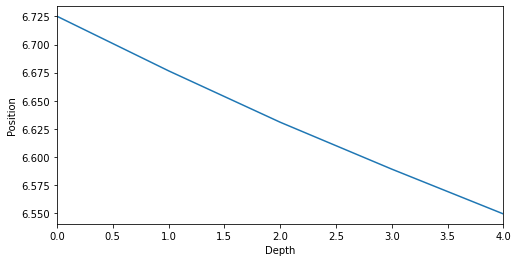

In [24]:
# data
data = {
    'loss': losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[8,4])
plt.plot(losses)
plt.xlabel('Depth')
plt.xlim(0, n_epoch - 1)
plt.ylabel('Position')
plt.show()